In [207]:
import subprocess
import numpy as np
import mdtraj as md
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg
%pylab inline

print "DSSP (Define Secondary Structure of Proteins) Hydrogen Bonding Algorithm for G protein\n"
print "‘H’ : Helix       ‘G’ : 3-helix (3/10 helix)\n'E’ : Beta ladder ‘B’ : Beta-bridge\n‘C’ : Random Coil ‘T’ : Hydrogen bonded turn\n"
gro_reference = '/home/karl/VoelzLab/ProteinG/gro/p8600/protein_only.gro'
traj_references = '/media/karl/VAV6/PROJ8600/RUN%d/CLONE%d/frame%d.xtc'
nruns=150
clone=2
trajs = [[] for i in range(nruns)]

#loads trajectories for 1 clone in every run in project.
def load_runs():
    for run in tqdm_notebook(range(nruns), desc='Loading Trajs.'):
        time.sleep(0.01)
        frame = int(subprocess.check_output('ls /media/karl/VAV6/PROJ8600/RUN%d/CLONE%d/frame*.xtc | wc -l' % (run,clone),shell=True))
        if frame >= 300: #if you have a lot of runs, try reducing amount by only selecting ones with long traj lengths
            for frm in range(frame):
                loadtrajs = md.load(traj_references%(run,clone,frm),top=gro_reference)
                trajs[run].append(loadtrajs)
load_runs()
#np.save('trajs',trajs) to save them to disk

Populating the interactive namespace from numpy and matplotlib
DSSP (Define Secondary Structure of Proteins) Hydrogen Bonding Algorithm for G protein

‘H’ : Helix       ‘G’ : 3-helix (3/10 helix)
'E’ : Beta ladder ‘B’ : Beta-bridge
‘C’ : Random Coil ‘T’ : Hydrogen bonded turn




In [208]:
#Removes empty trajectory files
trajs2 = [t for t in trajs if t != []]
#print trajs2

In [209]:
#removes trajectories with negative traj. length
trajs3 = [t for t in trajs2 if t[-1].time[-1]>0]
#print trajs3

In [210]:
#Removes 1st frame of every trajectory except the first one to avoid redundant DSSP calculations (ie last frame of gen1 = first frame of gen2)       
#comment out the function call if you don't need

trajs4 = [[] for i in range(len(trajs3))]
def remove_redundancy():
    for run in range(len(trajs3)):
        for traj in range(len(trajs3[run])):
            if traj==0:
                trajs4[run].append(trajs3[run][traj])
            else:
                trajs4[run].append(trajs3[run][traj][1:101])
remove_redundancy()
print len(trajs4) # if 0, load up another clone!

4


In [211]:
dssp = [[] for i in range(len(trajs4))]
def calculate_dssp():
    for run in tqdm_notebook(range(len(trajs4)), desc='DSSP Progress'):
        for traj in range(len(trajs4[run])):
            dssp[run].append(md.compute_dssp(trajs4[run][traj]))
            time.sleep(0.01)
    #np.save('dssp',dssp)
calculate_dssp()

In [212]:
#Takes each trajectory, extracts every frame (100ps), and appends it to a list to give full trajectory length
totalrestime=[[]for i in range(len(dssp))]
for run in range(len(dssp)):
    for traj in range(len(trajs4[run])):
        for ts in trajs4[run][traj].time:
            totalrestime[run].append(ts)

helix=[[] for i in range(len(dssp))]
betasheet=[[] for i in range(len(dssp))]
coil=[[] for i in range(len(dssp))]

#Gets DSSP classification from md.compute_dssp, sums up individual codes(eg H,C,B..etc) per frame, appends them to
#individual lists with lengths = total trajectory length
for run in range(len(dssp)):
    for traj in range(len(dssp[run])):
        for ts in range(len(dssp[run][traj])):
            helixsum=0
            betasum=0
            coilsum=0
            for code in range(len(dssp[run][traj][ts])): # for i in range length 3rd dimension
                if dssp[run][traj][ts][code] == 'H' or dssp[run][traj][ts][code] == 'I' or dssp[run][traj][ts][code] == 'G':
                    helixsum+=1
                elif dssp[run][traj][ts][code] == 'C' or dssp[run][traj][ts][code] == 'S' or dssp[run][traj][ts][code] == 'T':
                    coilsum+=1
                elif dssp[run][traj][ts][code] == 'E' or dssp[run][traj][ts][code] == 'B':
                    betasum+=1
            helix[run].append(helixsum)
            coil[run].append(coilsum)
            betasheet[run].append(betasum)

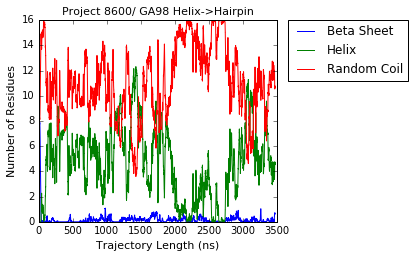

In [213]:
time_in_ns=[[]for i in range(len(totalrestime))]
for run in range(len(totalrestime)):
    for ts in totalrestime[run]:
        ns=ts*0.001
        time_in_ns[run].append(ns)
        
helixcounts=[[] for i in range(len(helix))]
coilcounts=[[] for i in range(len(coil))]
betasheetcounts=[[] for i in range(len(betasheet))]


for run in range(len(time_in_ns)):
    for i in range(len(time_in_ns[run])):
        helixcounts[run].append(helix[run][i])
        coilcounts[run].append(coil[run][i])
        betasheetcounts[run].append(betasheet[run][i])

smoothedbeta = sg(betasheetcounts[0], 89, 0) 
smoothedcoil = sg(coilcounts[0], 89, 0) 
smoothedhelix = sg(helixcounts[0], 89, 0) 

fig=plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.55, 0.70])
ax.plot(time_in_ns[0], smoothedbeta,label='Beta Sheet')
ax.plot(time_in_ns[0], smoothedhelix,label='Helix')
ax.plot(time_in_ns[0], smoothedcoil,label='Random Coil')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Trajectory Length (ns)', size=11)
ax.set_ylabel('Number of Residues', size=11)
ax.set_title('Project 8600/ GA98 Helix->Hairpin', size =11)
plt.show()
fig.savefig('DSSP_per_timePROJ8600.png')

#--------- for smoothing -------------

#smoothedbeta = sg(betacounts, 101, 1) 
#smoothedcoil = sg(coilcounts, 101, 1) 
#smoothedhelix = sg(helixcounts, 101, 1) 

#ax.plot(time_in_ns, smoothedbeta,label='Beta Sheet')
#ax.plot(time_in_ns, smoothedhelix,label='Helix')
#ax.plot(time_in_ns, smoothedcoil,label='Random Coil')

#------- Raw Data --------------------

#ax.plot(time_in_ns[0], helixcounts[0], label = 'Helix')
#ax.plot(time_in_ns[0], betasheetcounts[0], label='Beta Sheet')
#ax.plot(time_in_ns[0], coilcounts[0], label='Random Coil')


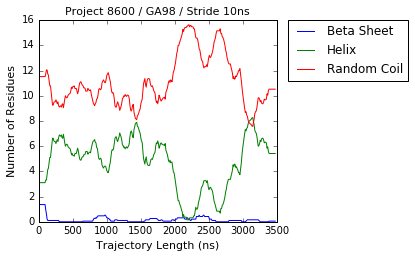

In [214]:
#same plot but with stride 10ns!
smoothedbeta_stride = sg(betasheetcounts[0][::100], 19, 0) 
smoothedcoil_stride = sg(coilcounts[0][::100], 19, 0) 
smoothedhelix_stride = sg(helixcounts[0][::100], 19, 0) 

fig=plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.55, 0.70])
ax.plot(time_in_ns[0][::100], smoothedbeta_stride,label='Beta Sheet')
ax.plot(time_in_ns[0][::100], smoothedhelix_stride,label='Helix')
ax.plot(time_in_ns[0][::100], smoothedcoil_stride,label='Random Coil')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_xlabel('Trajectory Length (ns)', size=11)
ax.set_ylabel('Number of Residues', size=11)
ax.set_title('Project 8600 / GA98 / Stride 10ns', size =11)
plt.show()
fig.savefig('DSSP_per_time_stride10_PROJ8600.png')
